# Population Statistics

## Imports

The following imports are required for the function to execute data retreival!

In [67]:
%pip install wbdata
%pip install pandas
%pip install iso3166
%pip install cufflinks
%pip install eep153_tools
%pip install plotly

import wbdata
import pandas as pd
import math
import iso3166
import plotly.offline as py
from scipy.optimize import newton
import plotly.graph_objs as go
import numpy as np
import cufflinks as cf
from matplotlib import animation as ani
cf.go_offline()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Population Statistics Function

Given any year, sex, age range, and country, the following function will retrieve the necessary data and display it as a pandas dataframe.

Calling the function should be something like: **population(year, sex, age_range, location)**

Thought process of how the function works is commented

In [34]:
def population(year, sex, age_range, location):

    # Checks to see if location is World or WLD, otherwise, get alpha3 name and country name
    if location.lower() == "world" or location.lower() == "wld":
        alpha3_name = "WLD"
        real_name = "World"
    else:
        alpha3_name = iso3166.countries.get(location).alpha3                        
        real_name = iso3166.countries.get(location).apolitical_name

    low = age_range[0]
    high = age_range[1]

    def age_helper(age_range):
        
        range = []
        
        # Rounds age up/down to fit within the age range of datasets
        lower_bound = 5 * math.floor(min(age_range)/5)
        upper_bound = 5 * round(max(age_range)/5)
        
        # Loops for every dataframe that contains lower_bound and lower_bound + 4 (example: {"6064"})
        # The upper_bound + 1 counters the rounding down mechanism and ensures that the age ranges are within the dataframe
        while lower_bound < min(79, upper_bound + 1):
            range.append("{:02}{:02}".format(lower_bound, lower_bound + 4))
            lower_bound += 5

        # Adds the ID "80UP" to range when the upper_bound is greater than 80
        if upper_bound >= 80:
            range.append("80UP")

        return range
        
    # Filters sex parameter into a specific ID to access
    if sex.lower() == "male":
        new_sex = "MA"
    elif sex.lower() == "female":
        new_sex = "FE"
    else:
        print("Please enter 'Male' or 'Female'")
        
    indicatorLst = []
    ageLst = []
    keyLst = []
    finalDt = {}
    for i in age_helper(age_range):
        df_input = "SP.POP.{}.{}".format(i, new_sex)
        ageLst.append("{}-{}".format(i[:2], i[2:]))
        indicatorLst.append(df_input)

    for age, indicator in zip(ageLst, indicatorLst):
        if "MA" in indicator:
            keyLst.append("Population ages {}, male".format(age))
        else:
            keyLst.append("Population ages {}, female".format(age))

    for key, value in zip(indicatorLst, keyLst):
        finalDt[key] = value

    # Dataframe retrieval and compiles all indicators within finalDt given the year, age range, and population
    wb_dataframe = wbdata.get_dataframe(finalDt, country=alpha3_name, source=40)
    data = wb_dataframe.query("date=='{}'".format(year)).sum(axis=0).tolist() # returns list of population for each year
    total_population = sum(data) # calculates total population
    final_dataframe = pd.DataFrame({'Country': real_name, 'Year': year, 'Age Range': ageLst, 'Population': data})

    # I originally had the function return the dataframe before, but the unit testing required checking for accurate population assertion statements
    print("In the year {}, there are {} {}s aged {} to {} living in {}.".format(year, total_population, sex, low, high, real_name))
    return total_population

In [19]:
population(year=2002, sex='Male', age_range=(0, 200), location='China')

In the year 2002, there are 654865008.0 Males aged 0 to 200 living in China.


654865008.0

## Unit Test

These are some assertion statements for testing the total population of certain inputs. 

If all the test cases pass, the final output should be "All test cases have passed!"

While this is **not** an exhaustive list of assertions and edge cases, it handles the main functionality of what the project requires.

In [20]:
def population_testing():
    
    assert population(year=2000, sex='Male', age_range=(0, 100), location='WLD') > 0, "Population should be greater than 0."
    assert population(year=2000, sex='Female', age_range=(0, 100), location='WLD') < 7e9, "Population should be less than 7 billion."
    assert population(year=1966, sex='Male', age_range=(18, 26), location='USA') < 21e6, "Population should be less than 21 million."
    assert population(year=1966, sex='Female', age_range=(18, 26), location='USA') > 21e6, "Population should be greater than 21 million."
    assert population(year=1966, sex='Female', age_range=(3, 89), location='Australia') < 6e6, "Population should be less than 6 million."
    assert population(year=2002, sex='Male', age_range=(0, 200), location='China') > 6e7, "Population should be greater than 600 million."
    
    print("All test cases have passed!")

population_testing()

In the year 2000, there are 3088840113.0 Males aged 0 to 100 living in World.
In the year 2000, there are 3055481431.0 Females aged 0 to 100 living in World.
In the year 1966, there are 20919571.0 Males aged 18 to 26 living in United States of America.
In the year 1966, there are 21544800.0 Females aged 18 to 26 living in United States of America.
In the year 1966, there are 5785020.0 Females aged 3 to 89 living in Australia.
In the year 2002, there are 654865008.0 Males aged 0 to 200 living in China.
All test cases have passed!


# Population Dataframe


The code below includes a function that returns a pandas Dataframe indexed by Region, or Country and Year, with columns giving counts of people in different age-sex groups

All data is sources from the World Bank Data API. To access and explore data, you can use wbdata.get_topic(), wbdata.get_indicator or wbdata.get_source.
For population estimates data, we need to access **Source 40:** 

In [21]:
source_id = 40 #Population Estimates and Projections

Now, we can define a function that will allow us to create a dataframe indexed by country, year, age group and sex.

 the population ranges from the data set include :00-04, 05-09, 10-14, 15-19, 20-24, 25-29, 30-34, ..., 70-74 

In [22]:
def pop_df(year='2023', group='all', age_lower=0, age_upper=100, location='world'):
    df = pop_df_helper(year, age_lower, age_upper, location)

    #Creates distinct columns grouped by sex      
    if group == 'males':
        return df.drop(columns = ['Female'])
    elif group == 'females':
        return df.drop(columns = ['Male'])
    else:
        total_pop = df["Female"] + df["Male"]
        df["Total"] = total_pop
    return df

# Returns a list of input strings for population age ranges
def pop_df_helper(year, age_lower, age_upper, location):
    if location != 'world':
        country_alpha3 = iso3166.countries.get(location).alpha3
        country_name = iso3166.countries.get(location).apolitical_name
    else:
        country_alpha3 = 'WLD'
        country_name = 'World'
    inputs = list_of_age_inputs(age_lower, age_upper)

    #create indicator dictionaries required for the dataset's API
    indicator_dict_m = {}
    indicator_dict_f = {}
    for i in inputs:
        key_m = "SP.POP.{}.{}".format(i, 'MA')
        key_f = "SP.POP.{}.{}".format(i, 'FE')
        value = "{}-{}".format(i[:2], i[2:])
        indicator_dict_m[key_m] = value
        indicator_dict_f[key_f] = value

    source_id = 40
    wbdf_m = wbdata.get_dataframe(indicator_dict_m, country=country_alpha3, source=source_id)
    wbdf_f = wbdata.get_dataframe(indicator_dict_f, country=country_alpha3, source=source_id)
    datas_m = wbdf_m.query("date=='{}'".format(year)).sum(axis=0).tolist()
    datas_f = wbdf_f.query("date=='{}'".format(year)).sum(axis=0).tolist()
    df = pd.DataFrame({
        'Country': country_name,
        'Year': year,
        'Age': list(indicator_dict_m.values()),
        'Female': datas_f,
        'Male': datas_m
    })
    return df

# Returns a list of input strings for population age ranges
def list_of_age_inputs(age_lower, age_upper):
    def round_down(n):
        return max(0, n - n % 5)

    def round_up(n):
        return n - n % 5 + 5

    results = []
    r_lower_bound, r_upper_bound = round_down(age_lower), round_up(age_upper)   
    while r_lower_bound < min(79, r_upper_bound):
        results.append("{:02d}{:02d}".format(r_lower_bound, r_lower_bound + 4))
        r_lower_bound += 5
    if age_upper >= 80:
        results.append('80UP')
    return results

## Example call

In [23]:
year = 2017 #1960 to 2050 (projections)
group = 'all' #males/females/all
age_lower = 13 #rounds to nearest 5 (actual range: 10 to 65)
age_upper = 61
location = 'bangladesh' #accepts country names/abbreviations, 'world

In [24]:
df = pop_df(year, group, age_lower, age_upper, location)
df

,Country,Year,Age,Female,Male,Total
0,Bangladesh,2017,10-14,8225272.0,8483492.0,16708764.0
1,Bangladesh,2017,15-19,8211225.0,8447567.0,16658792.0
2,Bangladesh,2017,20-24,7591111.0,7723966.0,15315077.0
3,Bangladesh,2017,25-29,7149808.0,7148678.0,14298486.0
4,Bangladesh,2017,30-34,6663791.0,6318060.0,12981851.0
5,Bangladesh,2017,35-39,6026943.0,5472318.0,11499261.0
6,Bangladesh,2017,40-44,5263200.0,4749203.0,10012403.0
7,Bangladesh,2017,45-49,4437729.0,4192227.0,8629956.0
8,Bangladesh,2017,50-54,3491474.0,3445787.0,6937261.0
9,Bangladesh,2017,55-59,3005996.0,2862495.0,5868491.0


# Top 5 Nations with Highest Internal Displacement Due to Natural Disaster, in Comparison with Global Rates

For this project's topic, we will be pulling from Source 2: Worldwide Development Indicators

In [35]:
SOURCE=2 
wbdata.get_indicators(source=SOURCE)

id                         name
-------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------
AG.AGR.TRAC.NO             Agricultural machinery, tractors
AG.CON.FERT.PT.ZS          Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS             Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2             Agricultural land (sq. km)
AG.LND.AGRI.ZS             Agricultural land (% of land area)
AG.LND.ARBL.HA             Arable land (hectares)
AG.LND.ARBL.HA.PC          Arable land (hectares per person)
AG.LND.ARBL.ZS             Arable land (% of land area)
AG.LND.CREL.HA             Land under cereal production (hectares)
AG.LND.CROP.ZS             Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2          Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS          Rural land area where elevation is below 5 me

In [36]:
disp_stat = wbdata.get_dataframe({'VC.IDP.NWDS':'Internally displaced persons, new displacement associated with disasters (number of cases)'})
#top_five = disp_stat.groupby("country").sort_values("Internally displaced persons, new displacement associated with disasters (number of cases)", ascending=False)
disp_stat.head(50)

Internally displaced persons, new displacement associated with disasters (number of cases)
country                     date                                                                                            
Africa Eastern and Southern 2022                                          4296440.0                                         
                            2021                                          2338890.0                                         
                            2020                                          3585560.0                                         
                            2019                                          2727102.0                                         
                            2018                                          1810544.0                                         
                            2017                                          2179294.0                                         
                            2016                                           873020.0                                         
                            2015                                           905597.0                                         
                            2014                                           579067.0                                         
                            2013                                          1065100.0                                         
                            2012                                           910420.0                                         
                            2011                                           495700.0                                         
                            2010                                           463750.0                                         
                            2009                                                NaN                                         
                            2008                                           517600.0                                         
                            2007                                                NaN                                         
                            2006                                                NaN                                         
                            2005                                                NaN                                         
                            2004                                                NaN                                         
                            2003                                                NaN                                         
                            2002                                                NaN                                         
                            2001                                                NaN                                         
                            2000                                                NaN                                         
                            1999                                                NaN                                         
                            1998                                                NaN                                         
                            1997                                                NaN                                         
                            1996                                                NaN                                         
                            1995                                                NaN                                         
                            1994                                                NaN                                         
                            1993                                                NaN                                         
                            1992  

### Resetting the dataframe index, so that each country and its corresponding year is a row:


In [37]:
new_df = disp_stat.reset_index()
new_df

,country,date,"Internally displaced persons, new displacement associated with disasters (number of cases)"
0,Africa Eastern and Southern,2022,4296440.0
1,Africa Eastern and Southern,2021,2338890.0
2,Africa Eastern and Southern,2020,3585560.0
3,Africa Eastern and Southern,2019,2727102.0
4,Africa Eastern and Southern,2018,1810544.0
...,...,...,...
16753,Zimbabwe,1964,NaN
16754,Zimbabwe,1963,NaN
16755,Zimbabwe,1962,NaN
16756,Zimbabwe,1961,NaN


### This table groups each country, sums up the amount of internally displaced people per year, and sorts the rows from most to least displaced people:

In [38]:
disp_stat_tbl= new_df.groupby("country").apply(sum).drop(["country","date"], axis=1).sort_values("Internally displaced persons, new displacement associated with disasters (number of cases)", ascending=False)
disp_stat_tbl.head(30)

,"Internally displaced persons, new displacement associated with disasters (number of cases)"
country,
World,375928016.0
Low & middle income,353416369.0
IDA & IBRD total,350508163.0
Middle income,326863046.0
IBRD only,250758876.0
Lower middle income,196602011.0
Early-demographic dividend,194082969.0
East Asia & Pacific,187423617.0
East Asia & Pacific (excluding high income),182160023.0


### Selecting the top five nations with the most aggregate internal displacement:

In [39]:
index_aggregated_top_five_rates=[0,15,17,19,29,33]
top_five_tbl=disp_stat_tbl.iloc[index_aggregated_top_five_rates]
top_five_tbl

,"Internally displaced persons, new displacement associated with disasters (number of cases)"
country,
World,375928016.0
China,96677000.0
Philippines,59574000.0
India,55923000.0
Pakistan,24753700.0
Bangladesh,17045000.0


### This function pulls internal displacement data according to Source 2 for any country, creating an individual data frame for each individual inputted country:

In [40]:
def get_country_data(country_name): 
    """select specific country's internal displacement over time from data set, reindexes the data frame, and """
    
    df = new_df.loc[new_df['country'] == country_name].reset_index().drop(["index"], axis=1)
    df = df.drop(columns = ['country'])
    df = df.rename(columns = {'Internally displaced persons, new displacement associated with disasters (number of cases)': 
                              country_name})
    return df

#top_five_visual.iplot(title="Internal Displacement Over Time",xTitle='Year',yTitle='Internal Displacement')

In [41]:
world=get_country_data('World')
china=get_country_data('China')
philippines=get_country_data('Philippines')
india=get_country_data('India')
pakistan=get_country_data('Pakistan')
bangladesh=get_country_data('Bangladesh')
bangladesh 

,date,Bangladesh
0,2022,1524000.0
1,2021,99000.0
2,2020,4443000.0
3,2019,4084000.0
4,2018,78000.0
...,...,...
58,1964,NaN
59,1963,NaN
60,1962,NaN
61,1961,NaN


#### This combines each individual country's dataframe through merging them with the common year, and creates a line plot over time:

[Text(0.5, 0, 'years'), Text(0, 0.5, 'millions displaced')]

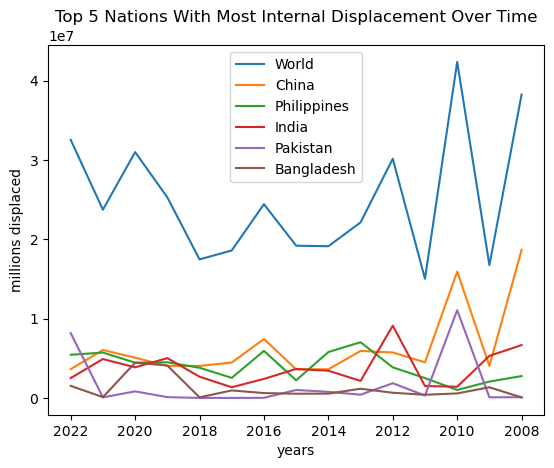

In [42]:
combined_df=world.merge(china, on ='date').merge(philippines, on='date').merge(india, on='date').merge(pakistan, on='date').merge(bangladesh, on='date') 
plot_countries=combined_df.plot(x='date', y=['World', 'China', 'Philippines', 'India', 'Pakistan', 'Bangladesh'], title= 'Top 5 Nations With Most Internal Displacement Over Time')
plot_countries.set(xlabel="years", ylabel="millions displaced")

#### From this graph, we see that 2010 had large increases in internally displaced people due to natural disasters overall in the world, followed by a corresponding spike in both China and Pakistan.

## Which percentage of these nations lives in exposure to droughts, floods, extreme temperatures?

##### Topic 46 covers Sustainable Development Goals

In [52]:
SOURCE=46
wbdata.get_indicators(source=SOURCE)

id                        name
------------------------  --------------------------------------------------------------------------------------------------------------------------------------------
AG.LND.FRST.K2            Forest area (sq. km)
AG.LND.FRST.ZS            Forest area (% of land area)
AG.YLD.CREL.KG            Cereal yield (kg per hectare)
BN.CAB.XOKA.GD.ZS         Current account balance (% of GDP)
BN.KLT.PTXL.CD            Portfolio Investment, net (BoP, current US$)
BX.KLT.DINV.CD.WD         Foreign direct investment, net inflows (BoP, current US$)
BX.KLT.DINV.WD.GD.ZS      Foreign direct investment, net inflows (% of GDP)
BX.TRF.PWKR.DT.GD.ZS      Personal remittances, received (% of GDP)
DT.DOD.DECT.GN.ZS         External debt stocks (% of GNI)
DT.ODA.ALLD.CD            Net official development assistance and official aid received (current US$)
DT.ODA.ODAT.CD            Net official development assistance received (current US$)
DT.ODA.ODAT.CD1           Net official 

In [45]:
drght_fld_xtremetemp= (wbdata.get_dataframe({'EN.CLC.MDAT.ZS':'Droughts, floods, extreme temperatures (% of population, average 1990-2009)'}).rename(columns = {'Droughts, floods, extreme temperatures (% of population, average 1990-2009)':'Droughts, floods, extreme temperatures (average % of population)'}).reset_index())
drght_fld_xtremetemp

,country,date,"Droughts, floods, extreme temperatures (average % of population)"
0,Africa Eastern and Southern,2022,NaN
1,Africa Eastern and Southern,2021,NaN
2,Africa Eastern and Southern,2020,NaN
3,Africa Eastern and Southern,2019,NaN
4,Africa Eastern and Southern,2018,NaN
...,...,...,...
16753,Zimbabwe,1964,NaN
16754,Zimbabwe,1963,NaN
16755,Zimbabwe,1962,NaN
16756,Zimbabwe,1961,NaN


#### Grouping by country, collecting average sum of % vulnerable population, and ranking from highest to lowest:


In [46]:
vulnerable=(drght_fld_xtremetemp.groupby(['country']).apply(sum)).drop(["country","date"], axis=1)
percent_vulnerable_sum=vulnerable.sort_values("Droughts, floods, extreme temperatures (average % of population)", ascending=False).reset_index()
percent_vulnerable_sum

,country,"Droughts, floods, extreme temperatures (average % of population)"
0,Eswatini,9.226586
1,Malawi,8.820493
2,China,7.950971
3,Niger,7.525066
4,Eritrea,7.323483
...,...,...
261,Latvia,0.000000
262,Least developed countries: UN classification,0.000000
263,Libya,0.000000
264,Liechtenstein,0.000000


### This function returns the index integer of any country input

In [47]:
def get_country_index(country_name):
    """Function returns index number of any country in data set"""

    risk= percent_vulnerable_sum.loc[percent_vulnerable_sum['country'] == country_name]
    return risk.index

In [49]:
get_country_index('China') #2
get_country_index('Philippines') #55
get_country_index('India') #14
get_country_index('Pakistan')#47
get_country_index('Bangladesh')#13

Int64Index([13], dtype='int64')

In [50]:
indexes=[2,55,14,47,13]
new_df_vulnerable=percent_vulnerable_sum.iloc[indexes]
new_df_vulnerable

,country,"Droughts, floods, extreme temperatures (average % of population)"
2,China,7.950971
55,Philippines,0.806385
14,India,4.356109
47,Pakistan,1.055342
13,Bangladesh,4.584694


## Bar chart of the population percentage of the top 5 nations with the highest internal displacement that is vulnerable to natural disasters and climate risk, specifically for droughts, floods, and extreme temperature

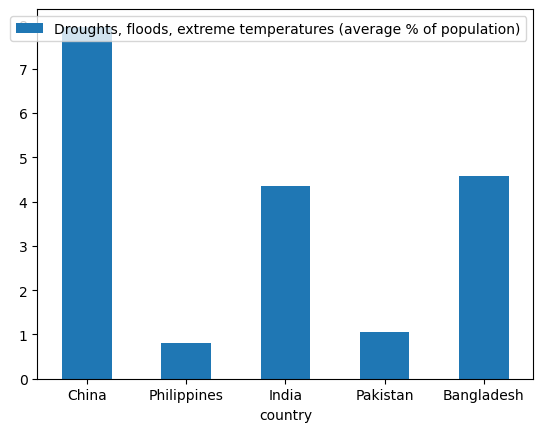

In [51]:
plot_data= pd.DataFrame({'Droughts, floods, extreme temperatures (average % of population)':['China', 'Philippines', 'India', 'Pakistan', 'Bangladesh'], 'val': [7.95,0.806,4.356,1.055,4.58]})
plot = new_df_vulnerable.plot.bar(x= 'country', y='Droughts, floods, extreme temperatures (average % of population)', rot=0)

#  Malthus

Among all the things ever written by social scientists (or “political philosophers”, to use a term he would have recognized), Malthus’ “Essay on Population” (1798) must be among the most influential. You can find the first edition at the link above. The main argument is spelled out in Chapter 1, which I encourage you to read. A key point of the essay begins with two postulata:

- First: That food is necessary to the existence of man.- 
Secondly: That the passion between the sexes is necessary and will remain nearly in its present state.

These lead to a conclusion: 
- Assuming then, my postulata as granted, I say, that the power of
population is indefinitely greater than the power in the earth to
produce subsistence for man.  Population, when unchecked, increases
in a geometrical ratio. Subsistence increases only in an
arithmetical ratio. A slight acquaintance with numbers will shew
the immensity of the first power in comparison of the second.

# Malthus meets math

In [54]:
P0 = 1
r = 0.02  # Rate of population growth

## for line
F0 = 10
m = 100

def food_production(t,m=m):
    return F0+m*t

def population(t,r=r):
    return P0*np.exp(r*t)

def choose_xaxis(r,m,x0=10):
    """
    Find a range of x so that curves intersect
    """
    tstar = -1
    try:
        while tstar <= 0:
            tstar = newton(lambda t: food_production(t,m) - population(t,r),x0,maxiter=1000)
            x0 = x0*10
        return np.linspace(0,tstar*1.1,100)
    except RuntimeError: # Failed to find root
        return np.linspace(0,1000,100)
import plotly.graph_objs as go
from ipywidgets import interactive, HBox, VBox
T = choose_xaxis(r,m)

data = [ dict(name ='Food production', 
              line= dict (color = 'red', width=6),
              x = T,
              y= [food_production (t) for t in T]),
              dict(name = 'Population', 
              line = dict (color = 'blue', width=6),
              x = T, 
              y=[population (t) for t in T])]
layout = dict()
f = go.FigureWidget (data=data, layout =layout)
def update_pop(r,m):
    T = choose_xaxis(r,m)
    f.data[1].y = [population(t,r) for t in T]
    f.data[0].x = T
    f.data[1].x = T

import numpy as np
import wbdata
import cufflinks as cf
cf.go_offline()

def fix_date_index(df):
    idx_vars = df.index.names
    new = df.reset_index()
    new.date = new.date.astype(int)
    return new.set_index(idx_vars)

## Food Production

Malthus thought that population would have to increase at an exponential rate. We’ve seen that in fact the rate of population increase has been roughly linear over the last six decades. (There are no guarantees about the future!)

### Finding data 

## How is agricultural production increasing?


We’ve seen that growth in food production is typically greater than population growth. But where is this growth coming from?

Food (and crops in particular) are the classical example of production. The “classical” economists in the 18th century, when most income came from agriculture, thought there were three main “factors” of production:

- Land
- Labor
- Capital boal

### Visualizing data on agriculture production

# The Living Production for the selected Countries

In [56]:
wbdata.get_topics()

  id  value
----  -------------------------------
   1  Agriculture & Rural Development
   2  Aid Effectiveness
   3  Economy & Growth
   4  Education
   5  Energy & Mining
   6  Environment
   7  Financial Sector
   8  Health
   9  Infrastructure
  10  Social Protection & Labor
  11  Poverty
  12  Private Sector
  13  Public Sector
  14  Science & Technology
  15  Social Development
  16  Urban Development
  17  Gender
  18  Millenium development goals
  19  Climate Change
  20  External Debt
  21  Trade

In [58]:
wbdata.get_indicators(topic=1)

id                    name
--------------------  ------------------------------------------------------------------------------------------
AG.AGR.TRAC.NO        Agricultural machinery, tractors
AG.CON.FERT.PT.ZS     Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS        Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2        Agricultural land (sq. km)
AG.LND.AGRI.ZS        Agricultural land (% of land area)
AG.LND.ARBL.HA        Arable land (hectares)
AG.LND.ARBL.HA.PC     Arable land (hectares per person)
AG.LND.ARBL.ZS        Arable land (% of land area)
AG.LND.CREL.HA        Land under cereal production (hectares)
AG.LND.CROP.ZS        Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2     Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS     Rural land area where elevation is below 5 meters (% of total land area)
AG.LND.FRST.K2        Forest area (sq. km)
AG.LND.FRST.ZS        Forest area (% of land area)

In [59]:
selected_five = ['CHN','PHL','PAK','BGD','IND','WLD']

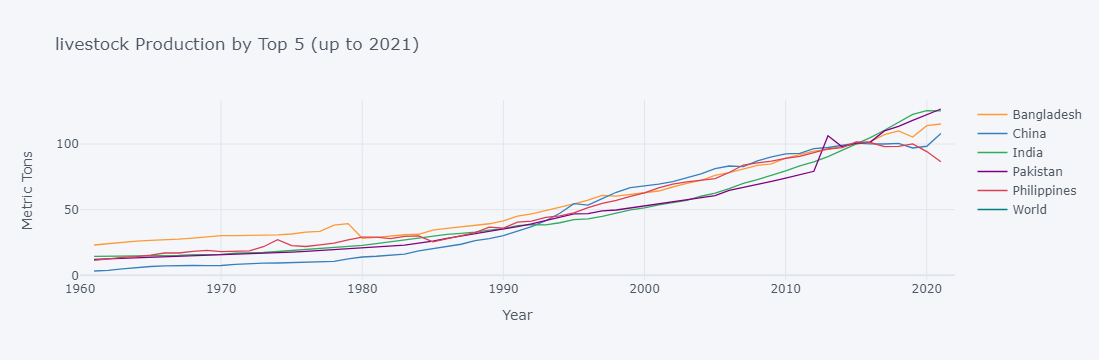

In [60]:
var_1 = {"AG.PRD.LVSK.XD":"Livestock index"}

livestock= fix_date_index(wbdata.get_dataframe(var_1,country=selected_five)).squeeze().unstack('country')

livestock.iplot(xTitle="Year",yTitle="Metric Tons",
              title="livestock Production by Top 5 (up to 2021)")

# The food production for the selected Countries

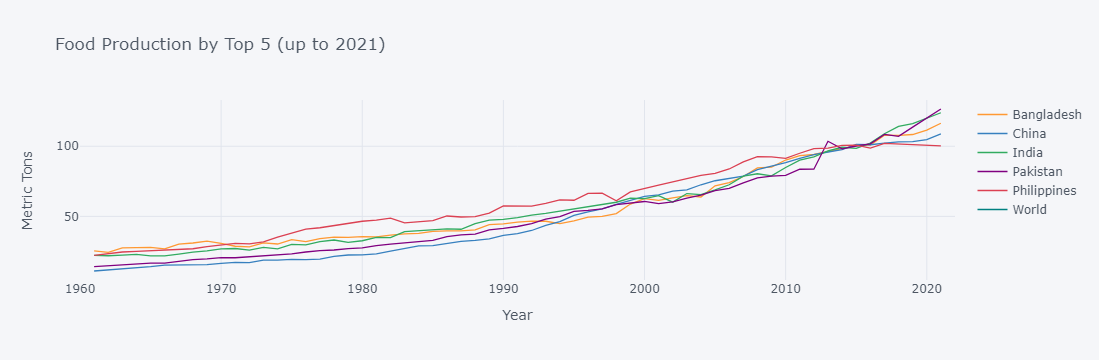

In [61]:
var_2 = { "AG.PRD.FOOD.XD":"Food index"}

food = fix_date_index(wbdata.get_dataframe(var_2,country=selected_five)).squeeze().unstack('country')

food.iplot(xTitle="Year",yTitle="Metric Tons",
              title="Food Production by Top 5 (up to 2021)")

# The crop production for the selected Countries

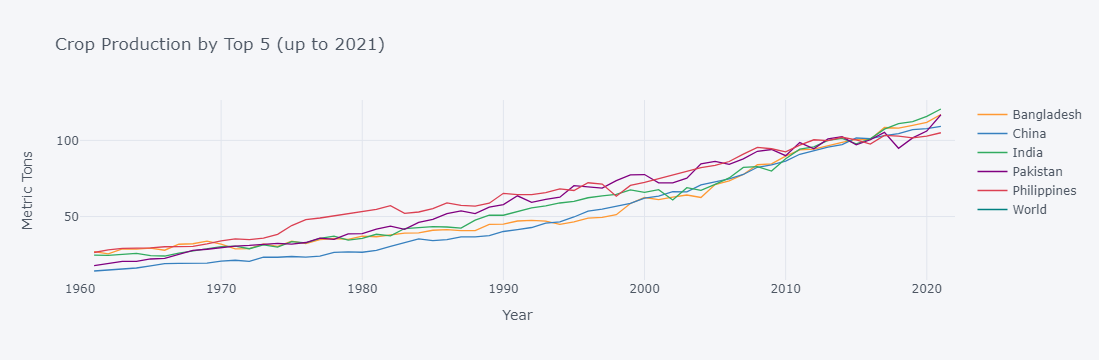

In [62]:
var_3 = {"AG.PRD.CROP.XD":"Crop index"}

crop = fix_date_index(wbdata.get_dataframe(var_3,country=selected_five)).squeeze().unstack('country')

crop.iplot(xTitle="Year",yTitle="Metric Tons",
              title="Crop Production by Top 5 (up to 2021)")

# The Population for the selected countries

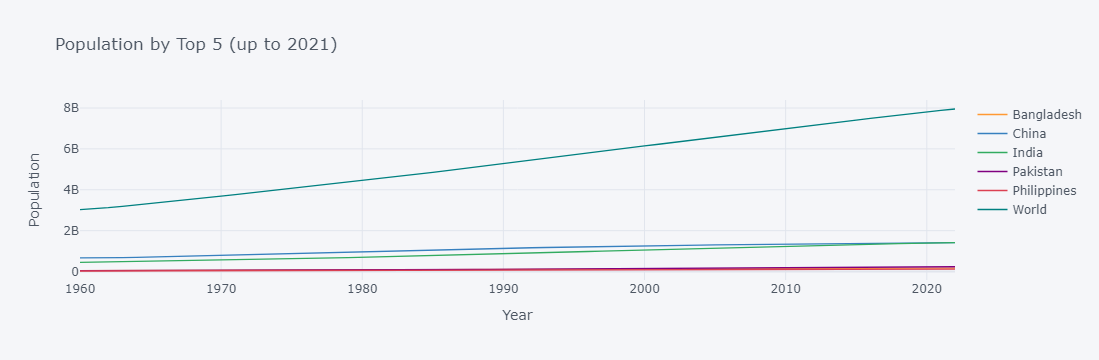

In [63]:
var_4 = {"SP.POP.TOTL":"Population"}

pop = fix_date_index(wbdata.get_dataframe(var_4,country=selected_five)).squeeze().unstack('country')

pop.iplot(xTitle="Year",yTitle="Population",
              title="Population by Top 5 (up to 2021)")

# World Population Pyramids

In [64]:
age_ranges = []
for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")

In [65]:
male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}

variables = male_variables
variables.update(female_variables)

In [66]:
world = wbdata.get_dataframe(variables,country="WLD")

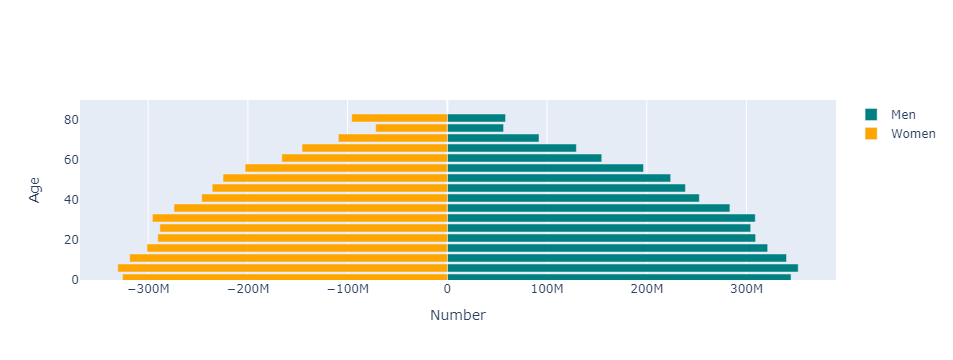

In [68]:
py.init_notebook_mode(connected=True)

layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))

year = 2021

bins = [go.Bar(x = world.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='teal'),
               hoverinfo='skip'
               ),

        go.Bar(x = -world.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
py.iplot(dict(data=bins, layout=layout))

# Change in the World Population Pyramid over time

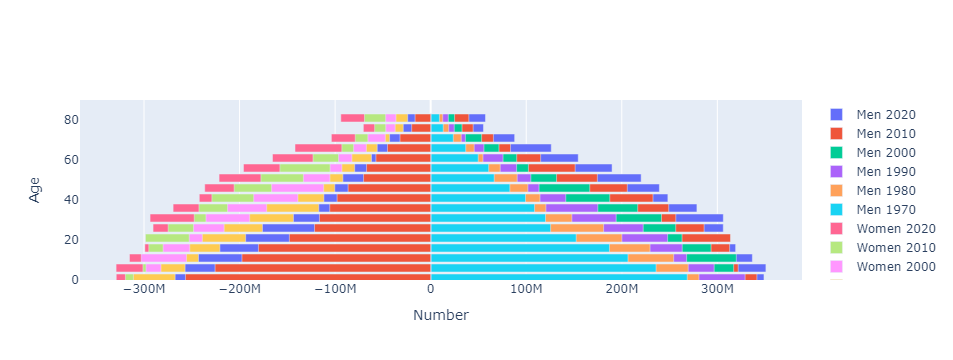

In [69]:
years = range(2020,1960,-10)

# This makes a list of graphs, year by year
bins = [go.Bar(x = world.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo='skip'
              )
        for year in years]
          
bins += [go.Bar(x = -world.loc[str(year),:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
         for year in years]

py.iplot(dict(data=bins, layout=layout))

# China population pyramid

In [70]:
china = wbdata.get_dataframe(variables,country='CHN')

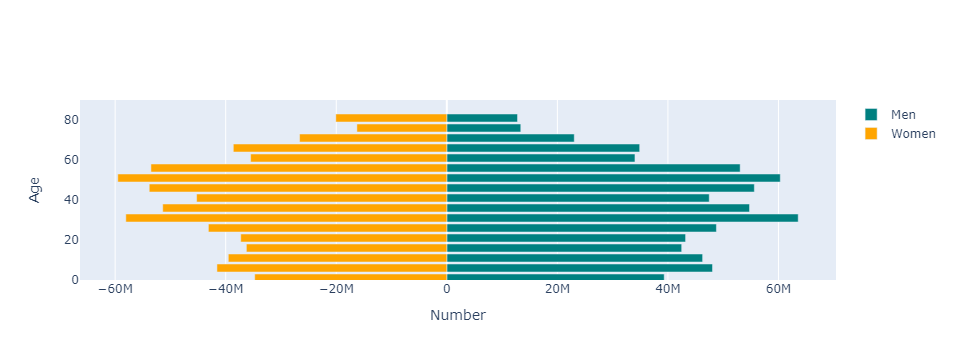

In [71]:
bins = [go.Bar(x = china.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='teal'),
               hoverinfo='skip'
               ),

        go.Bar(x = -china.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
py.iplot(dict(data=bins, layout=layout))

# Change in China's Population Pyramid over time

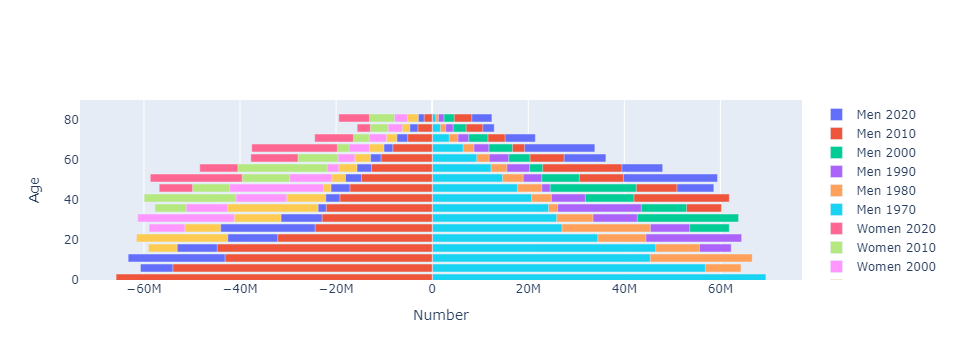

In [72]:
years = range(2020,1960,-10)

# This makes a list of graphs, year by year
bins = [go.Bar(x = china.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo='skip'
              )
        for year in years]
          
bins += [go.Bar(x = -china.loc[str(year),:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
         for year in years]

py.iplot(dict(data=bins, layout=layout))

# India Population Pyramid

In [73]:
india = wbdata.get_dataframe(variables,country='IND')

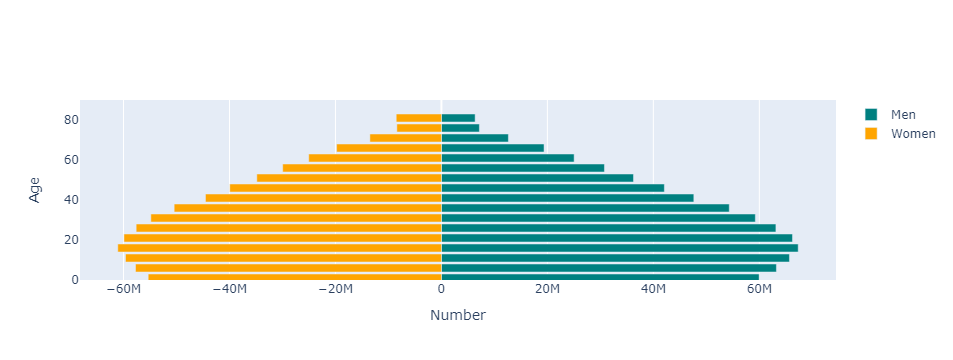

In [74]:
bins = [go.Bar(x = india.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='teal'),
               hoverinfo='skip'
               ),

        go.Bar(x = -india.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
py.iplot(dict(data=bins, layout=layout))

# Change in India's Population Pyramid over time

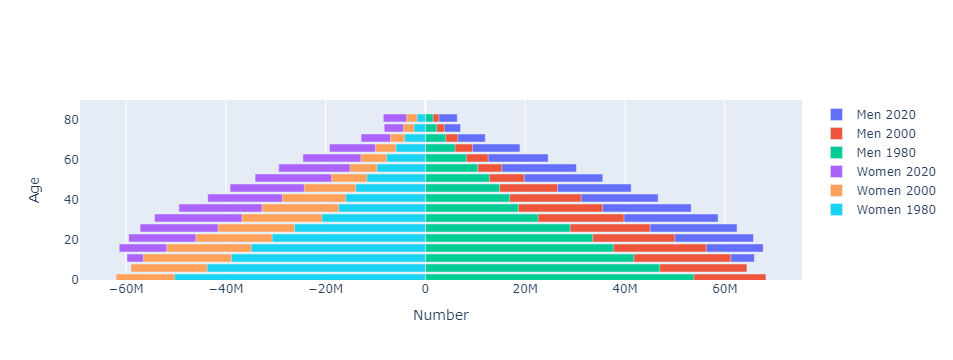

In [75]:
years = range(2020,1960,-20)

# This makes a list of graphs, year by year
bins = [go.Bar(x = india.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo='skip'
              )
        for year in years]
          
bins += [go.Bar(x = -india.loc[str(year),:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
         for year in years]

py.iplot(dict(data=bins, layout=layout))

# Pakistan Population Pyramid

In [76]:
pakistan = wbdata.get_dataframe(variables,country='PAK')

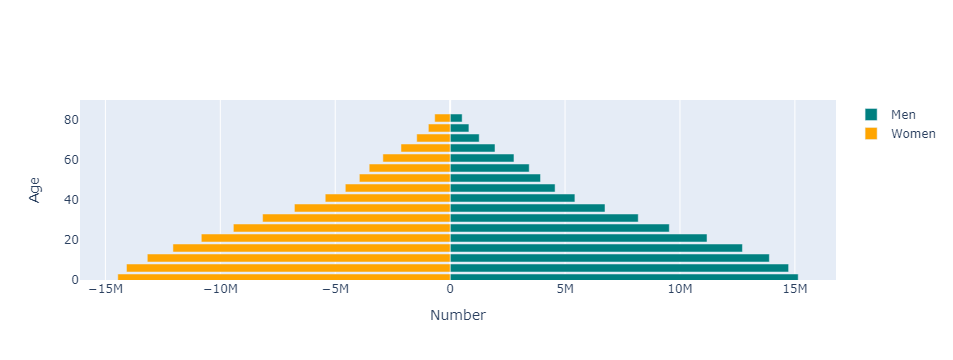

In [77]:
bins = [go.Bar(x = pakistan.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='teal'),
               hoverinfo='skip'
               ),

        go.Bar(x = -pakistan.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
py.iplot(dict(data=bins, layout=layout))


# Change in Pakistan's Population Pyramid over time

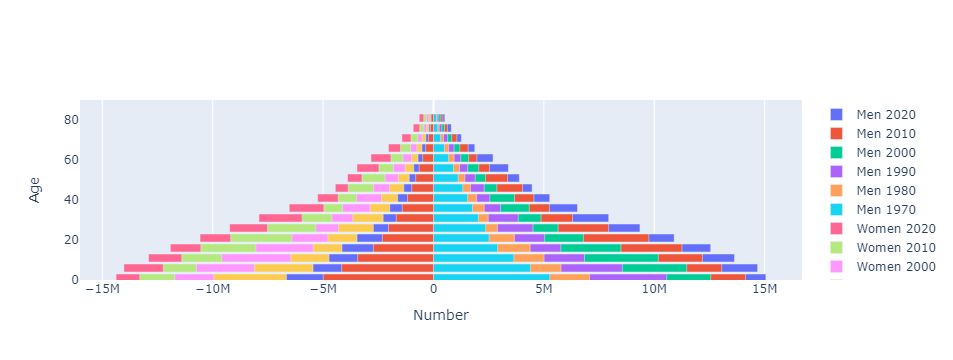

In [78]:
years = range(2020,1960,-10)

# This makes a list of graphs, year by year
bins = [go.Bar(x = pakistan.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo='skip'
              )
        for year in years]
          
bins += [go.Bar(x = -pakistan.loc[str(year),:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
         for year in years]

py.iplot(dict(data=bins, layout=layout))

# Philippines Population Pyramid

In [79]:
philippines = wbdata.get_dataframe(variables,country='PHL')

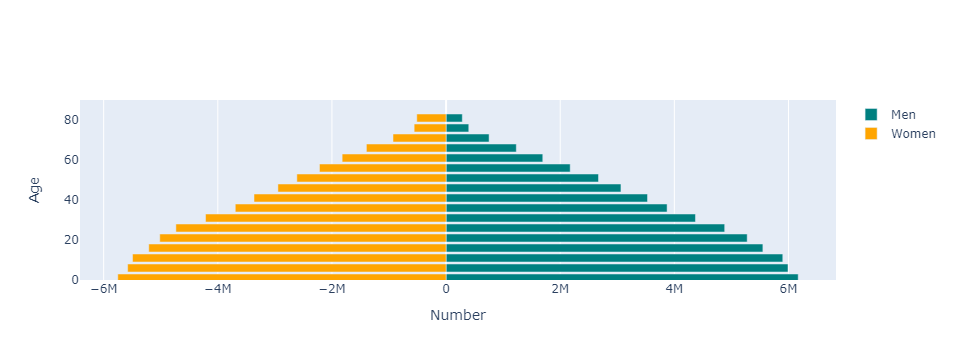

In [80]:
bins = [go.Bar(x = philippines.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='teal'),
               hoverinfo='skip'
               ),

        go.Bar(x = -philippines.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
py.iplot(dict(data=bins, layout=layout))

# Change in Philippines's Population Pyramid over time

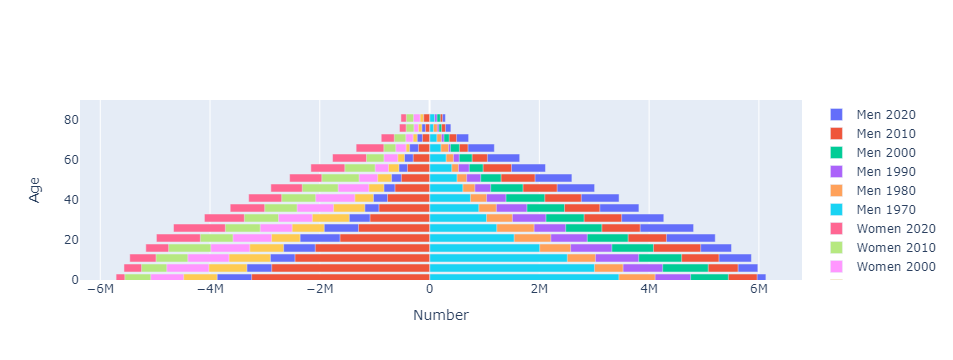

In [81]:
years = range(2020,1960,-10)

# This makes a list of graphs, year by year
bins = [go.Bar(x = philippines.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo='skip'
              )
        for year in years]
          
bins += [go.Bar(x = -philippines.loc[str(year),:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
         for year in years]

py.iplot(dict(data=bins, layout=layout))

# Bangladesh Population Pyramid

In [82]:
bangladesh = wbdata.get_dataframe(variables,country='BGD')

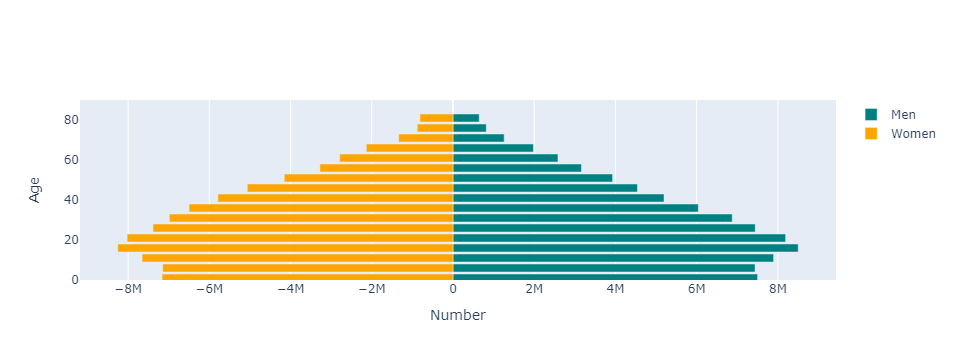

In [83]:
bins = [go.Bar(x = bangladesh.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='teal'),
               hoverinfo='skip'
               ),

        go.Bar(x = -bangladesh.loc[str(year),:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='orange'),
               hoverinfo='skip',
               )
        ]
py.iplot(dict(data=bins, layout=layout))

# Change in Bangladesh's Population Pyramid over time

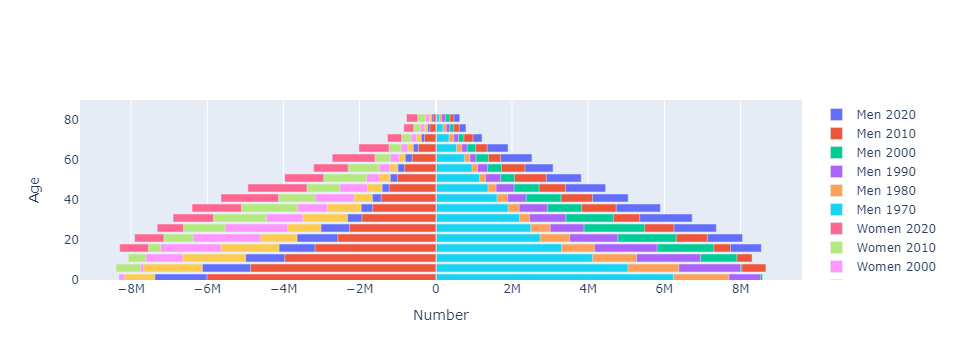

In [84]:
years = range(2020,1960,-10)

# This makes a list of graphs, year by year
bins = [go.Bar(x = bangladesh.loc[str(year),:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men {:d}'.format(year),
               hoverinfo='skip'
              )
        for year in years]
          
bins += [go.Bar(x = -bangladesh.loc[str(year),:].filter(regex="Female").values,
                y=[int(s[:2])+1 for s in age_ranges],
                orientation='h',
                name='Women {:d}'.format(year),
                hoverinfo='skip',
               )
         for year in years]

py.iplot(dict(data=bins, layout=layout))